In [1]:
%pylab inline --no-import-all
import matplotlib as mpl 
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
# matplotlib.rcParams['axes.grid'] = False
# matplotlib.rcParams['axes.facecolor'] = 'white'
import seaborn as sns
sns.set_style('whitegrid')
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)

cmap = 'viridis'
par.hdr

Populating the interactive namespace from numpy and matplotlib
../../../../crispy


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

# Constructing a fiducial frame with uniform electrons  

In [2]:
flux = 5e-4
inttime = 100
size = 1000
photoelectrons = flux*np.ones((size,size))*inttime
from crispy.tools.detector import readDetector

# verify with Bijan that the CIC/dark doesn't contribute to this formula
# if par.lifefraction>0.0:
#     photoelectrons[photoelectrons>0] *= np.minimum(np.ones(photoelectrons[photoelectrons>0].shape),1+par.lifefraction*0.51296*(np.log10(photoelectrons[photoelectrons>0])+0.0147233))    

In [3]:
par.dark=0.0
par.CIC=0.0
average = photoelectrons+par.dark*inttime+par.CIC

print np.std(average)
print np.mean(average/inttime)
print np.mean(average/inttime)-par.dark-par.CIC/inttime

1.04083408559e-16
0.0005
0.0005


## Electrons are generated following a Poisson process

0.222903981831
0.00049878
0.00049878


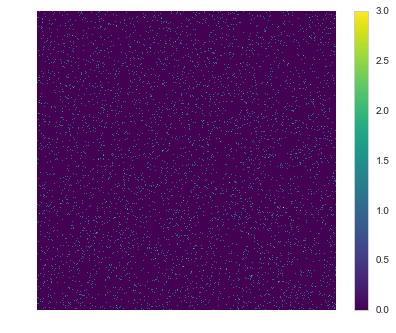

In [4]:
# calculate electron generation in the CCD frame
if par.poisson:
    atEMRegister = np.random.poisson(average)
else:
    atEMRegister = average

print np.std(atEMRegister)
print np.mean(atEMRegister/np.float(inttime))
print np.mean(atEMRegister/np.float(inttime))-par.dark-par.CIC/inttime    
plt.imshow(atEMRegister,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)


Percentage of pixels that are not 0 or 1: 0.1112%


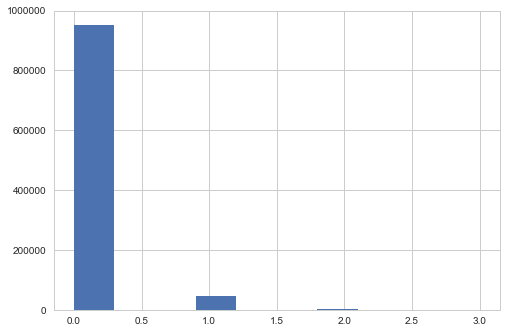

In [5]:
n, bins, patches = plt.hist(np.reshape(atEMRegister,-1),10)
num2 = len(atEMRegister[atEMRegister>1])
print "Percentage of pixels that are not 0 or 1: %.4f%%" % (np.float(num2)/size**2*100)

True
0.313627421142
0.000495855236325
0.000495855236325


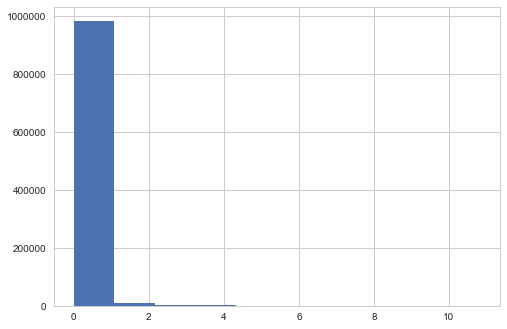

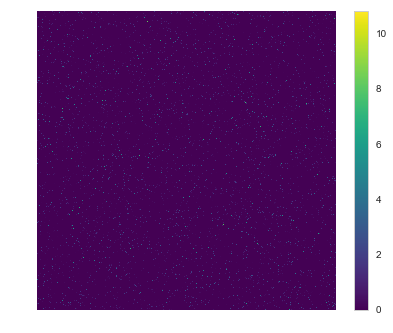

In [6]:
# calculate the number of electrons after the EM register
par.EMGain=2000
if par.EMStats:
    EMmask = atEMRegister>0
    afterEMRegister = np.zeros(atEMRegister.shape)
    afterEMRegister[EMmask] = np.random.gamma(atEMRegister[EMmask],par.EMGain,atEMRegister[EMmask].shape)
else:
    afterEMRegister = par.EMGain*atEMRegister

print par.EMStats
print np.std(afterEMRegister/par.EMGain)
print np.mean(afterEMRegister/np.float(inttime))/par.EMGain
print np.mean(afterEMRegister/np.float(inttime))/par.EMGain-par.dark-par.CIC/inttime    

n, bins, patches = plt.hist(np.reshape(afterEMRegister/par.EMGain,-1),10)
plt.figure()
plt.imshow(afterEMRegister/par.EMGain,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)


20.0
200
0.313779451227
0.000495641103332
0.000495641103332


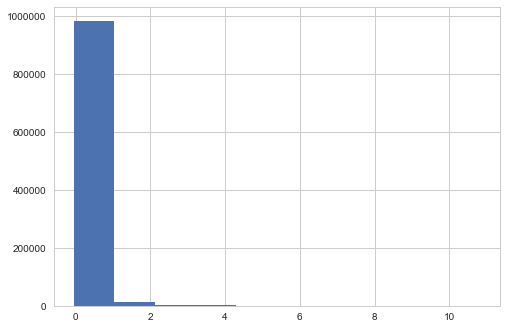

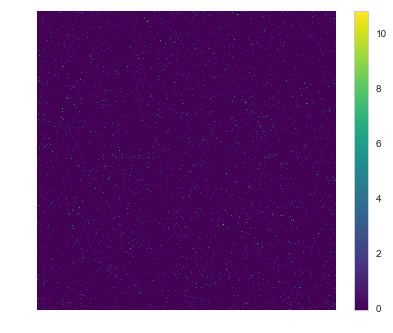

In [7]:
# add read noise
if par.RN>0:
    afterRN = afterEMRegister+np.random.normal(par.PCbias,par.RN,afterEMRegister.shape)
    # clip at zero
    afterRN[afterRN<0]=0
else:
    afterRN = afterEMRegister+par.PCbias
    
print par.RN
print par.PCbias
print np.std(afterRN/par.EMGain)
print np.mean((afterRN-par.PCbias)/np.float(inttime))/par.EMGain
print np.mean((afterRN-par.PCbias)/np.float(inttime))/par.EMGain-par.dark-par.CIC/inttime   

n, bins, patches = plt.hist(np.reshape((afterRN-par.PCbias)/par.EMGain,-1),10)
plt.figure()
plt.imshow((afterRN-par.PCbias)/par.EMGain,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)


True
4.0
0.211422524342
0.00046899
0.00046899


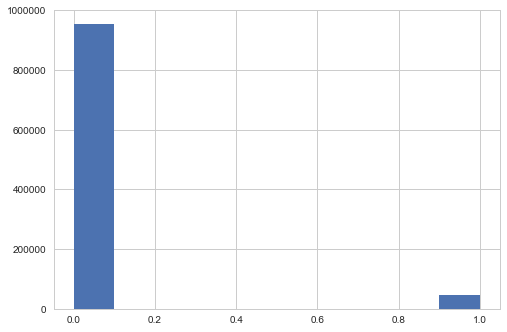

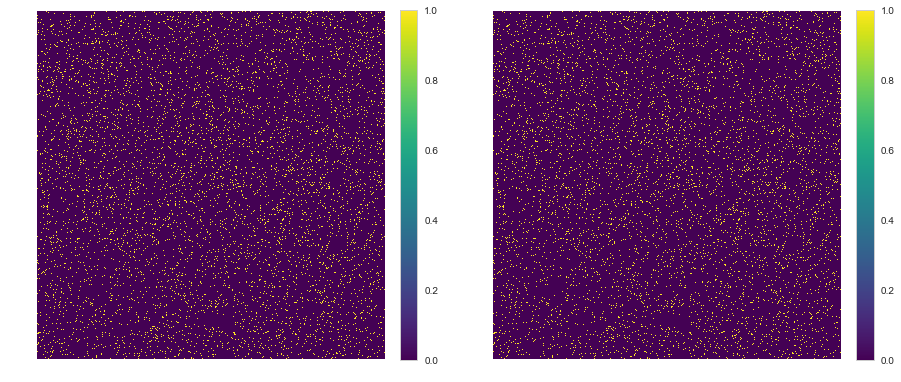

In [8]:
# add photon counting thresholding
par.PCmode=True
par.threshold = 4.0
if par.PCmode:
#     PCmask = afterRN>par.PCbias+par.threshold*par.RN
#     afterRN[PCmask]=1.0 #(afterRN[PCmask]-par.PCbias)/par.EMGain
#     afterRN[~PCmask]=0.
    PCmask = afterRN>par.PCbias+par.threshold*par.RN
    afterRN[PCmask]=1.0
    afterRN[~PCmask]=0.
#     STD = np.std(afterRN[PCmask])
#     MEAN = np.mean(afterRN[PCmask])
#     afterRN = afterRN > MEAN+STD
    
    
else:
    afterRN -= par.PCbias
    afterRN /= par.EMGain
    
print par.PCmode
print par.threshold
print np.std(afterRN)
print np.mean((afterRN)/np.float(inttime))
print np.mean((afterRN)/np.float(inttime))-par.dark-par.CIC/inttime    

n, bins, patches = plt.hist(np.reshape(afterRN,-1),10)
plt.figure(figsize=(15,12))
plt.subplot(121)
atEMRegister[atEMRegister>1]=1
plt.imshow(atEMRegister,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(afterRN,cmap=cmap)
plt.grid(False)
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

from astropy.io import fits
out = fits.HDUList(fits.PrimaryHDU(atEMRegister))
out.writeto("/Users/mrizzo/IFS/atEMRegister.fits",clobber=True)
out = fits.HDUList(fits.PrimaryHDU(afterRN))
out.writeto("/Users/mrizzo/IFS/afterRN.fits",clobber=True)

In [9]:
print np.sum(afterRN-atEMRegister)
print np.sum(atEMRegister)

-1849.0
48748
